### **Team -11, Predicting Protein Interaction using GCNs on Yeast Dataset**

**Note:** This notebook uses CUDA v.10.1. If your PC is not supported, run this notebook on Colab with GPU settings turned on.

In [1]:
!pip install stellargraph

In [2]:
from stellargraph.data import EdgeSplitter

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import pandas as pd
import networkx as nx
import os
import time

In [4]:
!pip install dgl-cu101

In [5]:
import dgl
from dgl import DGLGraph
dgl.load_backend('pytorch')
from dgl.nn.pytorch import conv as dgl_conv

Using backend: pytorch
Using backend: pytorch


In [27]:
class GCNModel(nn.Module):
    def __init__(self,in_feats,n_hidden,out_dim,layer_dim,hidden_layer_dim):
        super(GCNModel, self).__init__()
        

        self.gcn_layer_1 = dgl_conv.GraphConv(in_feats, n_hidden)

        self.gcn_layer_2 = dgl_conv.GraphConv(n_hidden, out_dim)

        self.lin_layer_1 = nn.Linear(out_dim, hidden_layer_dim)

        self.lin_layer_2 = nn.Linear(hidden_layer_dim,1)

    def forward(self, g, features, node_pairs, link_labels):
        x = features
        x = self.gcn_layer_1(g, features)
        x = F.relu(x)

        x = self.gcn_layer_2(g,x)
        x = F.relu(x)

        src = node_pairs[:,0]
        dst = node_pairs[:,1]

        emb_src = x[src]
        emb_dst = x[dst]

        z_tensor = torch.mul(emb_src,emb_dst)
        z_tensor = self.lin_layer_1(z_tensor)
        z_tensor = F.relu(z_tensor)
        z_tensor = self.lin_layer_2(z_tensor)
        sigm = nn.Sigmoid()
        z_tensor = sigm(z_tensor)
        return z_tensor.view(-1)
    
    def predict(self, features, g, node_pairs, link_labels):
        pred = self.forward(features, g, node_pairs, link_labels)
        loss = nn.BCELoss()(pred, link_labels)
        return loss, pred


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
raw_edge_list = open('/content/drive/My Drive/Colab Notebooks/DSLab/yeast.edgelist','r')
G = nx.Graph()
G = nx.parse_edgelist(raw_edge_list, delimiter='\t', create_using=G,nodetype=str, data=(('weight', float),))
# Get graph edges and nodes from networkx graph object
nodes = G.nodes
edges = G.edges

print("Graph's Nodes : {} / Edges : {}".format(len(nodes), len(edges)))

Graph's Nodes : 6526 / Edges : 532180


In [8]:
G.remove_edges_from(nx.selfloop_edges(G))

In [9]:
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

In [10]:
es_test = EdgeSplitter(G)
graph_test, examples_test, link_labels_test = es_test.train_test_split(p=0.1, method="global")

** Sampled 53049 positive and 53049 negative edges. **


In [11]:
es_train = EdgeSplitter(graph_test, G)
graph_train, examples_train, link_labels_train = es_train.train_test_split(
    p=0.7, method="global")
examples_train,examples_val, link_labels_train, link_label_val = train_test_split(examples_train,link_labels_train,test_size=0.033)

** Sampled 334212 positive and 334212 negative edges. **


In [12]:
def preprocess_graph(adj):
  adj = sp.coo_matrix(adj)
  adj_ = adj + sp.eye(adj.shape[0])
  rowsum = np.array(adj_.sum(1))
  degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
  features = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo() 
  print(features.shape)

  print(type(features))

  indices = np.vstack((features.row, features.col))
  values = features.data
  shape = features.shape
  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)

  features = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()
  return features

In [13]:
# #features =np.matrix([[i, i] for i in range(adj.shape[0])])
features = preprocess_graph(nx.adjacency_matrix(graph_train))
# #features = Variable(torch.FloatTensor(features), requires_grad=True)
# features

(6526, 6526)
<class 'scipy.sparse.coo.coo_matrix'>


RandomsearchCV

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {"n_hidden": [32, 64, 128, 256],
#               "epochs": np.range(5, 21),
#               "lr": [0.1, 0.01, 0.001],
#               "batch_size": [64, 128, 256]}

# gs = GridSearchCV(net, params, refit=False, scoring='r2', verbose=1, cv=10)

# gs.fit(X_trf, y_trf)

In [14]:
from torch.utils.data import Dataset,DataLoader

In [15]:
class EdgeDataset(Dataset):
    def __init__(self, x, y):
        super(EdgeDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [17]:
from torch.autograd import Variable

In [122]:
def create_model_and_train(lr,batch_size,n_hidden,hidden_layer_dim):
  g = DGLGraph()
  g.from_networkx(graph_train)
  g.readonly()
  n_epochs=20
  out_dim = 80
  model = GCNModel(in_feats = features.shape[0],n_hidden=n_hidden,out_dim=out_dim,layer_dim=out_dim,hidden_layer_dim=hidden_layer_dim)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  traindata = EdgeDataset(examples_train, link_labels_train)
  edge_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
  print("Training for {} epochs.".format(n_epochs))

  eval_report = {
      'train_losses':[],
      'train_rocs':[],
      'train_aps':[],
      'val_losses':[],
      'val_rocs':[],
      'val_aps':[],
      'times_per_epoch':[],
      'epochs':[],
      'learning_rate': list(np.full((n_epochs,),lr)),
      'batch_size':list(np.full((n_epochs,),batch_size)),
      'hidden1_dim':list(np.full((n_epochs,),n_hidden)) ,
      'hidden_layer_dim':list(np.full((n_epochs,),hidden_layer_dim))
  }

  sigm_val_pred = []
  for epoch in range(n_epochs):
    eval_report['epochs'].append(epoch+1)
    t = time.time()
    print('\n', end='')
    
    loss = 0.0
    train_roc = 0.0
    train_ap = 0.0
    for i,data in enumerate(edge_loader):
      #print("Step {}/{}......".format(i+1,))
      pairs, edges = data
      pairs = Variable(pairs).cuda()
      edges = Variable(edges.float()).cuda()
      
      optimizer.zero_grad()
      loss, pred = model.predict(g.to(device),torch.FloatTensor(features).cuda(), pairs, edges)
      loss.backward()
      optimizer.step()

      #pred = F.log_softmax(pred, dim=1)

      pred = pred.detach().to("cpu").numpy()
      #pred = 1*(pred>0.25)
      #pred = np.argmax(pred, axis=1)
      y_pred = []
      y_pred = np.append(y_pred, pred)
      train_roc = roc_auc_score(edges.detach().to("cpu").numpy(), y_pred)
      train_ap = average_precision_score(edges.detach().to("cpu").numpy(), y_pred)
      print("\repoch = {}/{} ({}/{}) - loss = {:.4f} roc_auc_score = {:.4f}"
      .format(epoch+1,n_epochs,i+1,int(examples_train.shape[0]/batch_size),
              loss,train_roc),end='',flush=True)
  
    eval_report['train_losses'].append(float(loss.detach().to('cpu').numpy()))
    eval_report['train_rocs'].append(train_roc)
    eval_report['train_aps'].append(train_ap)
    


    #validation scores
    val_loss, val_pred = model.predict(g.to(device),torch.FloatTensor(features).cuda(), 
                                      torch.tensor(examples_val).cuda(), 
                                      torch.FloatTensor(link_label_val).cuda())
    #val_pred = F.log_softmax(val_pred, dim=1)
    val_pred = val_pred.detach().to("cpu").numpy()
    sigm_val_pred = val_pred
    #val_pred = np.argmax(val_pred, axis=1)
    #val_pred = 1*(val_pred>0.5)
    val_y_pred = []
    val_y_pred = np.append(val_y_pred, val_pred)
    val_roc = roc_auc_score(link_label_val, val_y_pred)
    val_ap = average_precision_score(link_label_val,val_y_pred)

    
    eval_report['val_losses'].append(float(val_loss.detach().to('cpu').numpy()))
    eval_report['val_rocs'].append(val_roc)
    eval_report['val_aps'].append(val_ap)
    eval_report['times_per_epoch'].append(float(time.time()-t))

    print("\repoch = {}/{} - loss = {:.4f} roc_auc_score = {:.4f} val_loss = {:.4f} val_roc_auc_score = {:.4f} val_avg_precision = {:.4f} time= {:.5f}"
    .format(epoch+1,n_epochs,loss,train_roc,val_loss,val_roc,val_ap, time.time()-t),end='',flush=False)
  return model,eval_report,sigm_val_pred

In [ ]:
|#generate a new csv (do not run every time)

#import pandas as pd
#df = pd.DataFrame(columns=['epochs','learning_rate','batch_size','hidden1_dim',
#                           'hidden_layer_dim','train_losses','train_rocs',
#                           'train_aps','val_losses','val_rocs','val_aps',
#                           'times_per_epoch'])
#df.to_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv')

In [ ]:
#Appending evaluation results to the CSV file

def append_to_csv(eval_report):
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv', index_col=0)
  df2 = pd.DataFrame({
    'epochs':eval_report['epochs'],
    'learning_rate':eval_report['learning_rate'],
    'batch_size':eval_report['batch_size'],
    'hidden1_dim':eval_report['hidden1_dim'],
    'hidden_layer_dim':eval_report['hidden_layer_dim'],
    'train_losses':eval_report['train_losses'],
    'train_rocs':eval_report['train_rocs'],
    'train_aps':eval_report['train_aps'],
    'val_losses':eval_report['val_losses'],
    'val_rocs':eval_report['val_rocs'],
    'val_aps':eval_report['val_aps'],
    'times_per_epoch':eval_report['times_per_epoch'],
  })
  df = pd.concat([df,df2],ignore_index=True)
  df.to_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv')

###**Start Evaluation**

In [123]:
batch_s = 256
model,eval_report,sigmoid_val_pred = create_model_and_train(lr=0.01,batch_size=batch_s,n_hidden=256,hidden_layer_dim=16)
#append_to_csv(eval_report)

Training for 20 epochs.

epoch = 1/20 - loss = 0.4374 roc_auc_score = 0.8820 val_loss = 0.4453 val_roc_auc_score = 0.8792 val_avg_precision = 0.8664 time= 138.13435
epoch = 2/20 - loss = 0.4503 roc_auc_score = 0.8687 val_loss = 0.4295 val_roc_auc_score = 0.8812 val_avg_precision = 0.8688 time= 137.49864
epoch = 3/20 - loss = 0.4134 roc_auc_score = 0.8897 val_loss = 0.4275 val_roc_auc_score = 0.8829 val_avg_precision = 0.8707 time= 138.26634
epoch = 4/20 - loss = 0.3959 roc_auc_score = 0.9065 val_loss = 0.4226 val_roc_auc_score = 0.8862 val_avg_precision = 0.8734 time= 139.95765
epoch = 5/20 - loss = 0.3787 roc_auc_score = 0.9237 val_loss = 0.4167 val_roc_auc_score = 0.8886 val_avg_precision = 0.8761 time= 140.16044
epoch = 6/20 - loss = 0.3897 roc_auc_score = 0.8980 val_loss = 0.4234 val_roc_auc_score = 0.8891 val_avg_precision = 0.8757 time= 140.06258
epoch = 7/20 - loss = 0.3383 roc_auc_score = 0.9256 val_loss = 0.4144 val_roc_auc_score = 0.8903 val_avg_precision = 0.8780 time= 139.3

###**Make ROC curve**

In [124]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

In [143]:
def plot_roc_curve(y_true,y_pred):
  fpr, tpr, thresholds = roc_curve(y_true,y_pred, pos_label=1)
  auc_roc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic on Validation Set')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1.1], [0, 1.1],'r--')
  plt.xlim([0, 1.1])
  plt.ylim([0, 1.1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

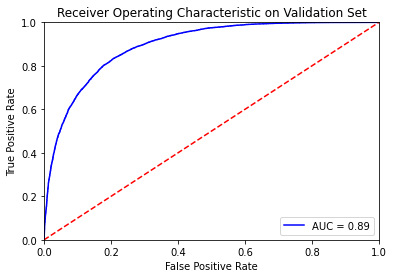

In [126]:
plot_roc_curve(link_label_val,sigmoid_val_pred)

In [127]:
testdata = EdgeDataset(examples_test,link_labels_test)
test_loader = DataLoader(testdata, batch_size=batch_s, shuffle=False)

In [128]:
g_test = DGLGraph()
g_test.from_networkx(graph_test)
g_test.readonly()
test_preds = []
test_true = []
test_losses = []
for i,Data in enumerate(test_loader):
  node_pairs, labels_test = Data
  with torch.no_grad():
    test_loss, test_pred = model.predict(g_test.to(device),torch.FloatTensor(features).cuda(), torch.tensor(node_pairs).cuda(), labels_test.float().cuda())
    
    test_losses.append(test_loss)
    test_pred = test_pred.detach().to("cpu").numpy()
    #test_pred = 1*(test_pred>0.5)
    
    test_preds = np.append(test_preds, test_pred)
    test_true = np.append(test_true,labels_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [129]:
test_roc = roc_auc_score(test_true, test_preds)
test_ap = average_precision_score(test_true,test_preds)
print("Test ROC AUC Score = {:.4f}\nTest Average Precision Score = {:.4f}".format(test_roc,test_ap))

Test ROC AUC Score = 0.8943
Test Average Precision Score = 0.8833


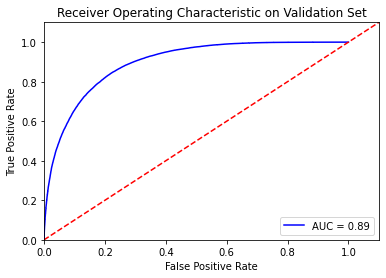

In [144]:
plot_roc_curve(test_true,test_preds)

In [132]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_true, test_preds)

In [134]:
np.max(precision)

1.0

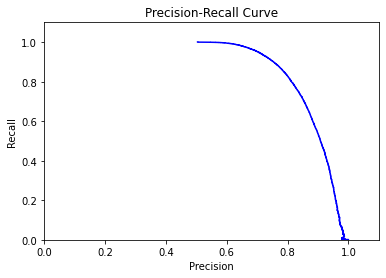

In [147]:
plt.title('Precision-Recall Curve')
plt.plot(precision,recall, 'b')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()